# Visual Odometry

Visual odmetry is process of determining the position and orientation of a robot by analyzing the associated camera images. This could really help donkey cars because the standard build doesn't have an odometer so there is now way to garantee a specific speed.

This notebook attempts to output the speed, change in angle. 

Much of this information is borrowed from 

In [1]:
from base import *

### Load Images
We are going to create a map of a track so 

In [2]:
images_folder_path = './data/fisheye_camera_calibration/'
img_list = glob.glob(os.path.join(images_folder_path,'*.jpg'))

### Load camera properties
We calculated these in the camera calibration script.

In [3]:
#Pull in the camera properties we calculated in the calibrate_camera notebook
w, h = img_size = default.camera_img_size
mtx = default.camera_mtx

focal_length = fx, fy = mtx[0,0], mtx[1,1]
print('focal length: {}'.format(focal_length))

optical_axis_center = cx, cy = mtx[0,2], mtx[1,2]
print('optical_axis_center: {}'.format(optical_axis_center))

k1, k2, k3, k4 = default.camera_dist 
print('distortion coefficients')
print(default.camera_dist)

focal length: (352.81900000000002, 330.38799999999998)
optical_axis_center: (309.88299999999998, 241.68000000000001)
distortion coefficients
[[-0.04651276]
 [-0.00205613]
 [-0.0176857 ]
 [ 0.0129772 ]]


In [4]:
def get_key_points(img):
    #first frame
    detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    prev_points = detector.detect(img)
    points = np.array([x.pt for x in prev_points], dtype=np.float32)
    return points

In [5]:
def track_key_points(prev_img, next_img, prev_points):
    
    lk_params = dict(winSize  = (21, 21),
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_img, 
                                                          next_img, 
                                                          prev_points, 
                                                          None, 
                                                          #**lk_params,
                                                          #winSize=(21, 21),
                                                          #criteria =(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
                                                         )
    status = status.reshape(status.shape[0])
    prev_points = prev_points[status == 1]
    next_points = next_points[status == 1]

    return prev_points, next_points

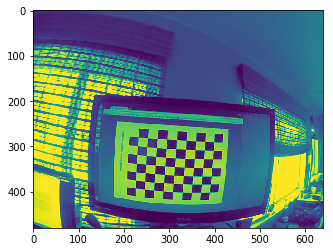

In [6]:
prev_img = cv2.imread(img_list[0], 0)
prev_points = get_key_points(prev_img)
plt.imshow(prev_img)

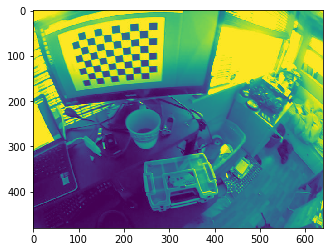

In [7]:
next_img = cv2.imread(img_list[1], 0)
plt.imshow(next_img)

In [8]:
print(type(prev_points[0][0]))
prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
print(len(next_points))
len(prev_points)

<class 'numpy.float32'>
1170


1170

In [9]:
def calculate_possition_change(prev_img, next_img, prev_points, next_points, 
                               fx, optical_axis_center):
    """
    Calculate the relative rotaion and translation between images.
    """
    
    #filter points to only those trackable between images
    prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
    
    
    E, mask = cv2.findEssentialMat(prev_points, 
                                   next_points, 
                                   focal=fx, 
                                   pp=optical_axis_center, 
                                   method=cv2.RANSAC, 
                                   prob=0.999, 
                                   threshold=1.0)
    
    _, R, t, mask = cv2.recoverPose(E, 
                                    next_points, 
                                    prev_points, 
                                    focal=fx, 
                                    pp = optical_axis_center)
    
    
    return R, t #relative rotation and translation


In [10]:
R, t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)
print('relative rotation matrix:')
print((np.round(R, 3)))

print('relative translation: {}')
print(t)

relative rotation matrix:
[[ 0.412 -0.082 -0.907]
 [-0.065  0.991 -0.12 ]
 [ 0.909  0.108  0.403]]
relative translation: {}
[[ 0.9162215 ]
 [ 0.13330444]
 [ 0.37784665]]


In [11]:
def update_possition(prev_R, prev_t, R, t):

    #absolute_scale = self.getAbsoluteScale(frame_id)
    absolute_scale = 1
    next_t = prev_t + absolute_scale*prev_R.dot(t) 
    next_R = R.dot(prev_R)
    
    return next_absolute_t

### Put it all together to map a path of the camera.

In [12]:
def log_path(img_list, cam):
    
    x, y, z = 0., 0., 0.
    log = [[x,y,z]]
    
    #first frame
    detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    prev_img = cv2.imread(img_list[0])
    prev_points = self.detector.detect(first_img)
    
    
    #second_frame
    prev_img = cv2.imread(img_list[1])
    prev_points = self.detector.detect(prev_img)
    
    
    for i in range(1,len(img_list)):
        next_img = cv2.imread(img_list[i])
        
        prev_points, next_points = track_features(prev_img,next_img, prev_points)
        
        R, t = calculate_possition_change(prev_)
        
        next_absolute_t = update_possition
        
        x, y, z = cur_t[0], cur_t[1], cur_t[2]
        
    
    

### Other sources
https://github.com/uoip/monoVO-python